<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pass vectorbt data to the agent

* **Pytorch Version** 



In [1]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [56]:
import vectorbt as vbt
import pandas as pd

start_date = '2009-01-01'
end_date = '2021-10-31'
DOW_30_TICKER = ['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']
data_vectorbt = vbt.YFData.download(
     DOW_30_TICKER,
     start=start_date,
     end=end_date,
     interval='1D'
 )


def preprocess_data(data):
    '''convert vectorbt format data to finrl format, and add indicators'''
    # dataframe schema is tuple with 7 elements: Open ,High ,Low ,Close ,Volume ,Dividends ,Stock Splits
    open = data.get()[0].stack(dropna=False).rename('open')
    high = data.get()[1].stack(dropna=False).rename('high')
    low = data.get()[2].stack(dropna=False).rename('low')
    close = data.get()[3].stack(dropna=False).rename('close')
    volume = data.get()[4].stack(dropna=False).rename('volume')
    close_rawFormat = data.get()[3]
    
    rsi_30 = vbt.RSI.run(close_rawFormat, 30).rsi.stack(dropna=False).rename(columns = {30 : 'rsi_30'})
    ma_30 = vbt.MA.run(close_rawFormat, 30).ma.stack(dropna=False).rename(columns = {30 : 'ma_30'})
    ma_60 = vbt.MA.run(close_rawFormat, 60).ma.stack(dropna=False).rename(columns = {60 : 'ma_60'})
    res = pd.concat([open,high,low,close,volume,rsi_30,ma_30,ma_60],axis=1).reset_index() # is slow because this line
    res = res.rename(columns = {'Date' : 'date', 'symbol' : 'tic'})
    res['date'] = res['date'].apply(lambda x : x.strftime('%Y-%m-%d'))
    fe = FeatureEngineer(
                    use_technical_indicator=False,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)
    processed = fe.preprocess_data(res)
    return processed

processed = preprocess_data(data_vectorbt)
processed

/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zo

/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zo

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3231, 8)
Successfully added vix


/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Successfully added turbulence index


,date,tic,open,high,low,close,volume,rsi_30,ma_30,ma_60,vix,turbulence
0,2008-12-31,AAPL,2.625211,2.679260,2.605973,2.606278,607541200.0,59.908163,2.780335,2.841795,40.000000,0.000000
1,2008-12-31,AMGN,43.437676,44.281939,43.399647,43.924458,6287200.0,59.908163,2.780335,2.841795,40.000000,0.000000
2,2008-12-31,AXP,14.442319,15.069198,14.394098,14.908460,9625600.0,59.908163,2.780335,2.841795,40.000000,0.000000
3,2008-12-31,BA,31.195798,32.290913,31.128291,32.005882,5443100.0,59.908163,2.780335,2.841795,40.000000,0.000000
4,2008-12-31,CAT,29.963740,30.923676,29.963740,30.628838,6277400.0,59.908163,2.780335,2.841795,40.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
93665,2021-10-28,UNH,448.595319,453.447669,448.119976,451.011597,1672600.0,64.621205,412.388166,411.987484,16.530001,75.498292
93666,2021-10-28,V,218.092662,218.828761,207.906710,208.732330,23199400.0,42.595810,225.210895,227.487207,16.530001,75.498292
93667,2021-10-28,VZ,51.494991,51.885476,51.368083,51.543800,18374700.0,45.074776,51.831031,52.499389,16.530001,75.498292
93668,2021-10-28,WBA,45.627879,45.889548,45.220831,45.647259,4843900.0,42.299346,46.605758,47.059735,16.530001,75.498292


In [26]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)
processed_full

,date,tic,open,high,low,close,volume,rsi_30,ma_30,ma_60,vix,turbulence
0,2008-12-31,AAPL,2.625210,2.679259,2.605973,2.606278,607541200.0,59.908196,2.780335,2.841794,40.000000,0.00000
1,2008-12-31,AMGN,43.437665,44.281927,43.399636,43.924446,6287200.0,59.908196,2.780335,2.841794,40.000000,0.00000
2,2008-12-31,AXP,14.442325,15.069204,14.394104,14.908465,9625600.0,59.908196,2.780335,2.841794,40.000000,0.00000
3,2008-12-31,BA,31.195809,32.290925,31.128302,32.005894,5443100.0,59.908196,2.780335,2.841794,40.000000,0.00000
4,2008-12-31,CAT,29.963731,30.923666,29.963731,30.628828,6277400.0,59.908196,2.780335,2.841794,40.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
135860,2021-10-28,UNH,448.595289,453.447638,448.119945,451.011566,1672600.0,64.621232,412.388161,411.987482,16.530001,75.49797
135861,2021-10-28,V,218.092662,218.828761,207.906710,208.732330,23199400.0,42.595797,225.210895,227.487208,16.530001,75.49797
135862,2021-10-28,VZ,51.494994,51.885479,51.368086,51.543804,18374700.0,45.074834,51.831032,52.499389,16.530001,75.49797
135863,2021-10-28,WBA,45.627879,45.889548,45.220831,45.647259,4843900.0,42.299353,46.605758,47.059735,16.530001,75.49797


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [28]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [29]:
train.tail()

,date,tic,open,high,low,close,volume,rsi_30,ma_30,ma_60,vix,turbulence
2892,2020-06-30,UNH,280.551458,288.212500,279.666741,286.754181,2932900.0,51.124605,286.997208,280.002903,30.43,12.91886
2892,2020-06-30,V,189.078409,191.309941,187.765157,190.737244,9040100.0,51.233293,191.485033,181.677680,30.43,12.91886
2892,2020-06-30,VZ,50.184839,50.522940,49.673124,50.376736,17414800.0,48.465911,51.012123,51.464679,30.43,12.91886
2892,2020-06-30,WBA,38.787097,39.210700,38.455582,39.035732,4782100.0,53.660862,39.135190,38.935130,30.43,12.91886
2892,2020-06-30,WMT,115.578878,116.461082,114.919646,116.121773,6836400.0,35.064430,117.787627,119.723274,30.43,12.91886


In [30]:
trade.head()

,date,tic,open,high,low,close,volume,rsi_30,ma_30,ma_60,vix,turbulence
0,2020-07-01,AAPL,90.153997,90.707087,89.855231,89.904610,110737200.0,67.961186,83.933768,77.717542,28.620001,53.06816
0,2020-07-01,AMGN,221.703759,241.198860,218.936225,240.153961,6575800.0,63.126952,214.858666,215.931668,28.620001,53.06816
0,2020-07-01,AXP,93.261323,94.935620,91.684937,92.086380,3301000.0,54.344115,97.244636,90.695523,28.620001,53.06816
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,59.284491,176.472335,155.614168,28.620001,53.06816
0,2020-07-01,CAT,123.829211,123.848342,120.479364,120.651642,2807800.0,58.750622,119.412836,113.646675,28.620001,53.06816


In [31]:
INDICATORS = ['rsi_30', 'ma_30','ma_60']

In [32]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 146


In [33]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [34]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [35]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [36]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [37]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50)

### Model 2: DDPG

In [38]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [39]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

KeyboardInterrupt: 

### Model 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

### Model 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [40]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [41]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [42]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [43]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574234
std        43.787196
min         0.000000
25%        14.966209
50%        24.124394
75%        39.162353
max       652.506833
Name: turbulence, dtype: float64

In [44]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45144378730663

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [45]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [46]:
trade.head()

,date,tic,open,high,low,close,volume,rsi_30,ma_30,ma_60,vix,turbulence
0,2020-07-01,AAPL,90.153997,90.707087,89.855231,89.904610,110737200.0,67.961186,83.933768,77.717542,28.620001,53.06816
0,2020-07-01,AMGN,221.703759,241.198860,218.936225,240.153961,6575800.0,63.126952,214.858666,215.931668,28.620001,53.06816
0,2020-07-01,AXP,93.261323,94.935620,91.684937,92.086380,3301000.0,54.344115,97.244636,90.695523,28.620001,53.06816
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,59.284491,176.472335,155.614168,28.620001,53.06816
0,2020-07-01,CAT,123.829211,123.848342,120.479364,120.651642,2807800.0,58.750622,119.412836,113.646675,28.620001,53.06816


In [47]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [48]:
df_account_value.shape

(336, 2)

In [49]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.504965e+06
332,2021-10-25,1.508471e+06
333,2021-10-26,1.508891e+06
334,2021-10-27,1.494264e+06
335,2021-10-28,1.495409e+06


In [50]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0,0,100,41,0,0,0,0,0,100,...,31,43,0,0,2,100,83,100,100,100
2020-07-02,0,0,100,41,0,0,0,0,0,100,...,31,43,0,0,2,100,83,100,100,100
2020-07-06,0,0,100,41,0,0,0,0,0,100,...,31,43,0,0,2,100,83,100,100,100
2020-07-07,0,0,100,41,0,0,0,0,0,100,...,31,43,0,0,2,100,83,100,100,100
2020-07-08,0,0,100,41,0,0,0,0,0,100,...,31,43,0,0,2,100,83,100,100,100


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [51]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.352291
Cumulative returns     0.495409
Annual volatility      0.144451
Sharpe ratio           2.168822
Calmar ratio           3.946629
Stability              0.944923
Max drawdown          -0.089264
Omega ratio            1.437034
Sortino ratio          3.320179
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.074948
Daily value at risk   -0.016956
dtype: float64


/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [52]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64


/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [53]:
df_account_value.loc[0,'date']

'2020-07-01'

In [54]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)


/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,35.229%
Cumulative returns,49.541%
Annual volatility,14.445%
Sharpe ratio,2.17
Calmar ratio,3.95
Stability,0.94
Max drawdown,-8.926%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.93,2020-09-02,2020-10-30,2020-11-09,49
1,4.89,2021-08-11,2021-09-30,2021-10-15,48
2,4.87,2021-01-12,2021-01-29,2021-02-17,27
3,4.69,2021-05-07,2021-06-18,2021-07-09,46
4,3.30,2020-11-16,2020-11-20,2020-12-02,13


/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/pyfolio/timeseries.py:54

Stress Events,mean,min,max
New Normal,0.12%,-3.29%,2.65%


/mnt/recoverData/linuxProgram/workspace/Finrl_python3.9/__pypackages__/3.9/lib/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


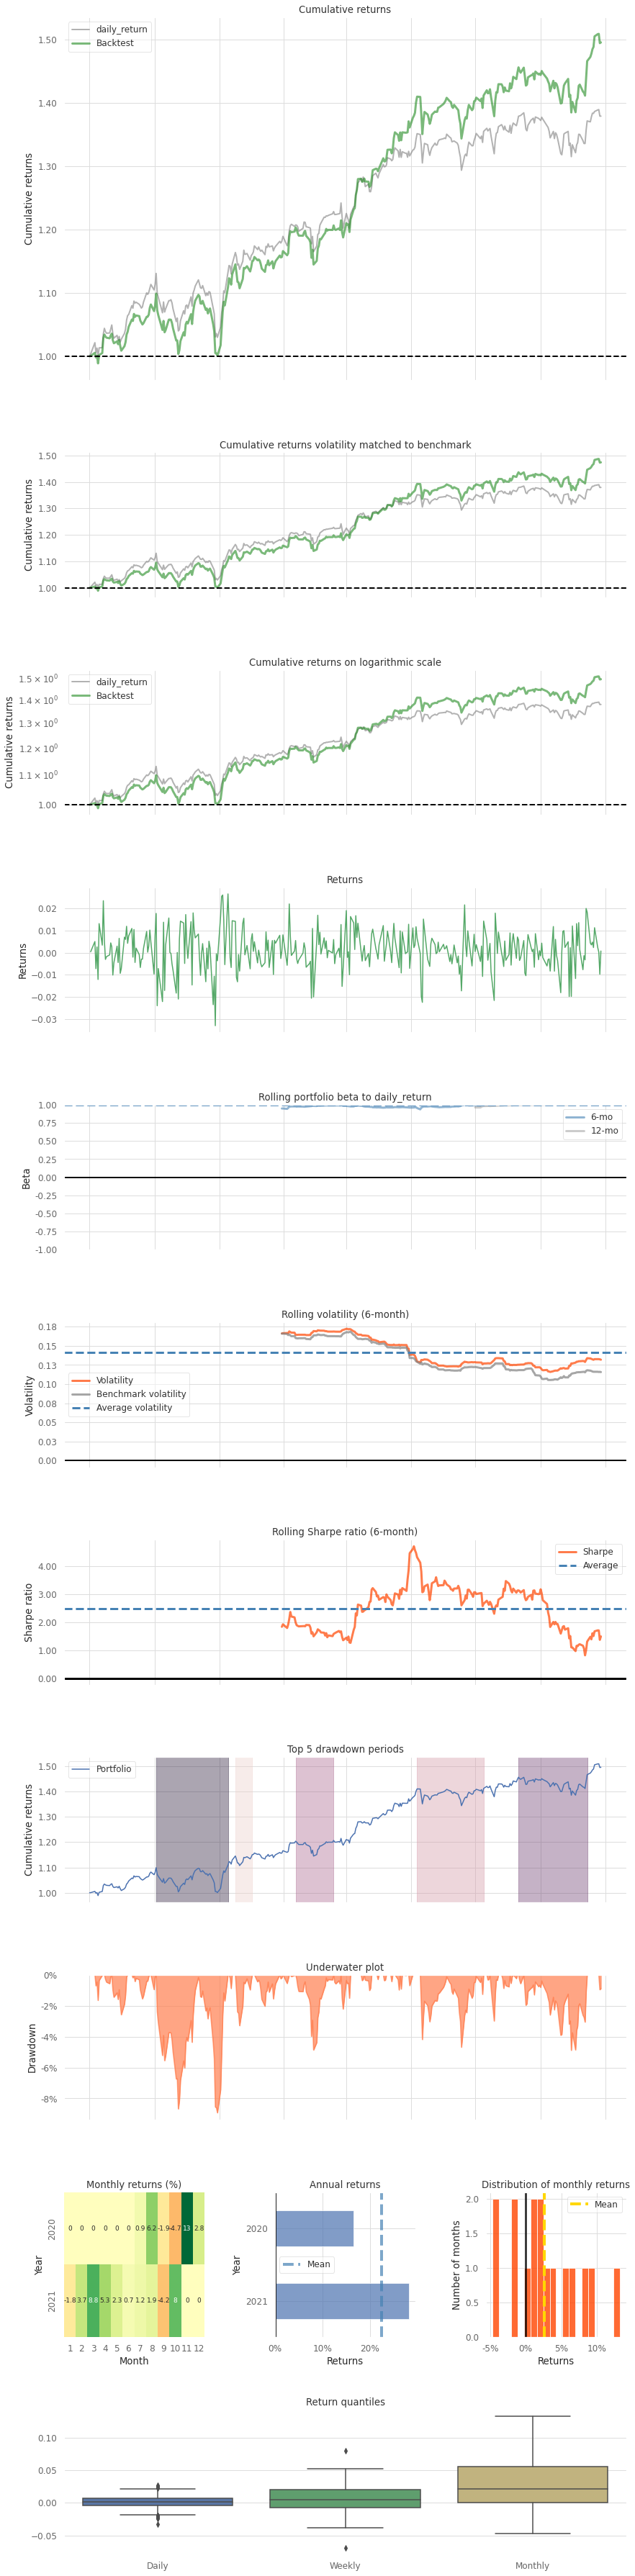

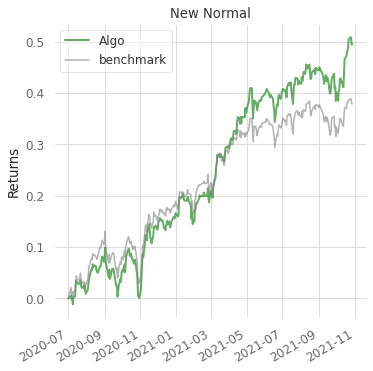

In [55]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])